<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC2</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC2: Redes Neuronales Convolucionales con KERAS

A lo largo de esta práctica vamos a implementar varios modelos de redes neuronales para clasificar las imágenes de la base de datos [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html).

La base de datos CIFAR10 está formada por imágenes en color de dimensiones 32x32 píxels que pertenecen a 10 clases:

- airplane (label 0)
- automobile (label 1)
- bird (label 2)
- cat (label 3)
- deer (label 4)
- dog (label 5)
- frog (label 6)
- horse (label 7)
- ship (label 8)
- truck (label 9)

Esta base de datos está compuesta de 60.000 registros que se dividen a su vez en 2 conjuntos: 50.000 imágenes para el conjunto de entrenamiento y 10.000 imágenes para el conjunto de test.

En el ejercicio llevaremos a cabo la tarea de construir varios modelos con el objetivo de conseguir la mayor precisión al realizar la clasificación de las imágenes. Para ello implementaremos y analizaremos los siguientes modelos: 
​
1. Una red neuronal artificial completamente conectada
2. Una red neuronal convolucional de una capa
3. Una red neuronal convolucional profunda

​
En todos los casos se utilizará la librería Keras con Tensorflow para la implementación del modelo, la compilación y el entrenamiento.

Finalmente, realizaremos una predicción de las imágenes con el mejor modelo implementado.

​
**Importante: Cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

## 1. Descarga, análisis y pre-procesado de los datos (1,5 puntos)

### 1.1 Descarga de datos
Empezamos importando algunos paquetes para la realización de la práctica y procedemos a descargar el dataset.

In [1]:
import numpy as np
from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
import matplotlib.pyplot as plt
import timeit
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
# Descarga el dataset CIFAR10 y hace la partición train/test
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


### 1.2 Análisis de los datos
<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> Representar la dimensión de las variables X_train, y_train, X_test e y_test.

Mostrar las imágenes de los primeros 10 registros del conjunto X_train junto con sus etiquetas en formato texto.

**Nota**: Al ser las imágenes de pequeño tamaño (32x32) se recomienda escalarlas a la hora de representarlas.
</div>

In [3]:
# Análisis del conjunto de datos descargado
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

|        | X_train   | X_test    | y_train  | y_test   |
|--------|-----------|-----------|----------|----------|
| Shapes | (50000, 32, 32, 3) | (10000, 32, 32, 3)  | (50000, 1) | (10000, 1) |

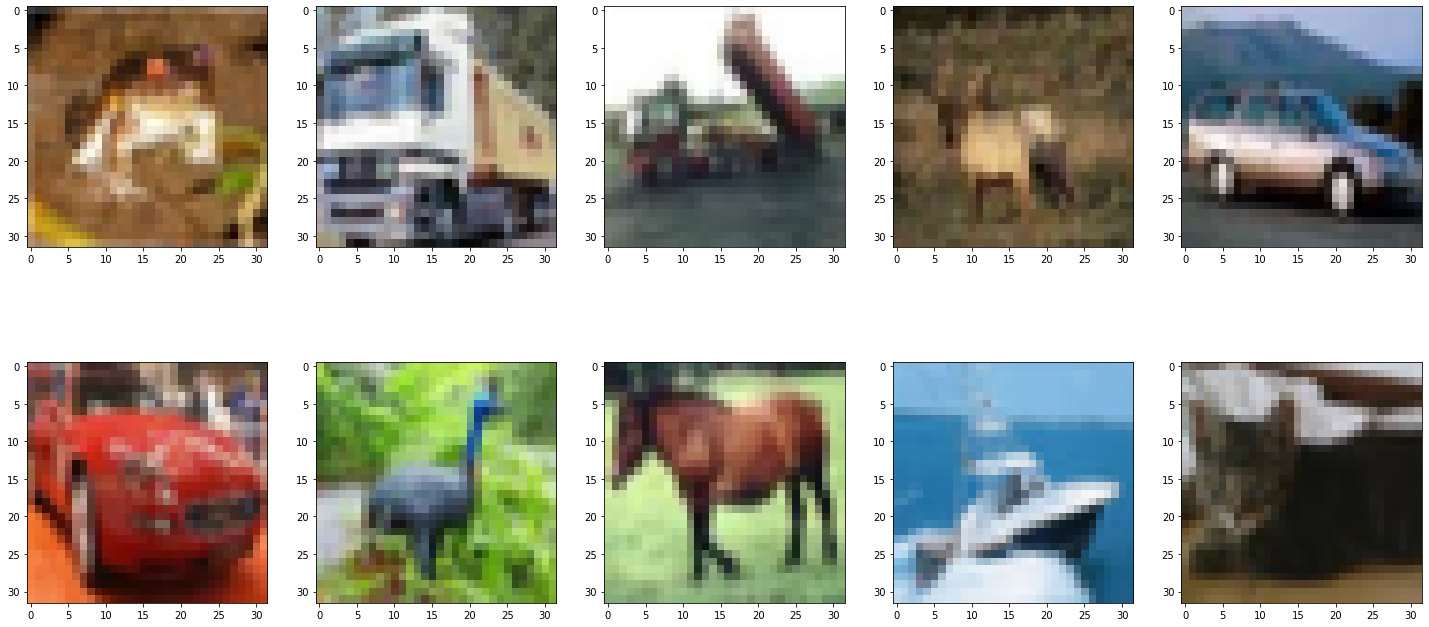

In [4]:
# Adjust proper figsize for scaling up the images
f, axarr = plt.subplots(2,5, figsize=(25,12))
axarr[0,0].imshow(X_train[0])

n = 0
for i in range(0,2):
  for j in range(0,5):
    axarr[i,j].imshow(X_train[n])
    n = n + 1


In [5]:
import cv2

# Convierte X_train y X_test a escala de grises
X_train_grey = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_train])
X_test_grey = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in X_test])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,25 pts.]:</strong> Representar la dimensión de las variables X_train_grey y X_test_grey.

Mostrar las imágenes de los primeros 10 registros del conjunto X_train_grey junto con sus etiquetas en formato texto.
</div>

In [6]:
X_train_grey.shape, X_test_grey.shape 

((50000, 32, 32), (10000, 32, 32))

|        | X_train_grey   | X_test_grey    |
|--------|-----------|-----------|
| Shapes | (50000, 32, 32) | (10000, 32, 32)  |

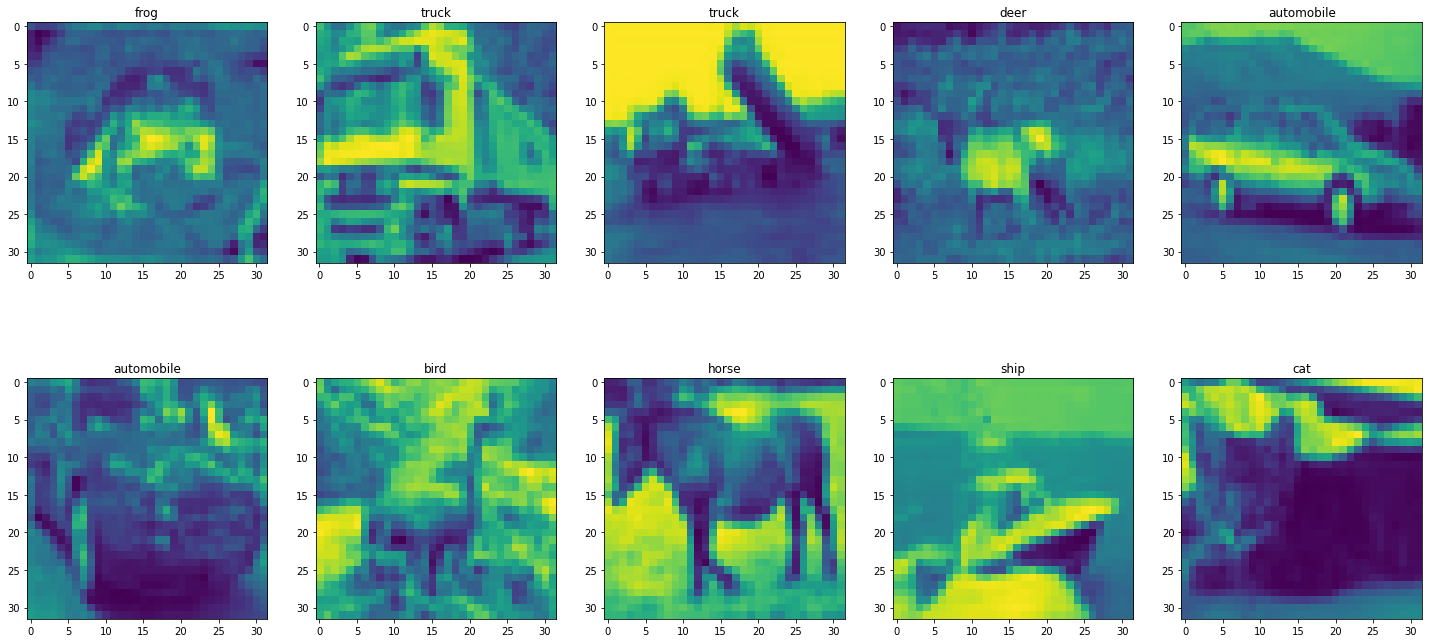

In [7]:
categories = dict({
      0: 'airplane',
      1: 'automobile',
      2: 'bird',
      3: 'cat',
      4: 'deer',
      5: 'dog',
      6: 'frog',
      7: 'horse',
      8: 'ship',
      9: 'truck',
  })

f, axarr = plt.subplots(2,5, figsize=(25,12))

n = 0
for i in range(0,2):
  for j in range(0,5):
    axarr[i,j].imshow(X_train_grey[n])
    axarr[i,j].set_title(categories[y_train[n][0]])
    n = n +1


El primer paso para entrenar una red neuronal consiste en pre-procesar los datos de entrenamiento y test para que cuadren con el formato esperado por las entradas y salidas de la red neuronal.

Empezaremos normalizando los datos de entrada para que estén en el rango [0,1] ya que, como podemos ver a continuación, se trata de valores enteros entre 0 y 255.

In [8]:
print("Los valores del primer registro de X_train_grey son: {}".format(X_train_grey[0]))

Los valores del primer registro de X_train_grey son: [[ 62  45  47 ... 128 121 120]
 [ 20   0   7 ...  82  77  82]
 [ 23   6  24 ...  78  78  68]
 ...
 [152 123 125 ... 117  27  32]
 [131 104 115 ... 136  58  51]
 [139 123 130 ... 174 112  90]]


In [9]:
# Determinar valores mínimo y máximo
v_min = np.min(X_train_grey)
v_max = np.max(X_train_grey)
print("Los valores mínimo y máximo son {} y {}.".format(v_min, v_max))

Los valores mínimo y máximo son 0 y 255.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> Normalizar los datos de entrada a la red para que estén comprendidos en el rango [0,1]. Imprimir los datos del primer registro una vez se ha llevado a cabo la normalización y comprobar de nuevo los valores máximo y mínimo. 
</div>

Dado que la sección de librerías importadas no incluye [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) realizaremos los cálculos manualmente tal cual se indica en la descripción de su implementación

In [10]:
# Manually compute MinMaxScaler as detailed in https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# Initialize values
min = 0
max = 1
X = X_train_grey
# Normalize
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_train_grey_norm = X_std * (max - min) + min
print("Los valores del primer registro de X_train_grey_norm son: {}".format(X_train_grey_norm[0]))

Los valores del primer registro de X_train_grey_norm son: [[0.24313725 0.17647059 0.18431373 ... 0.50196078 0.4745098  0.47058824]
 [0.07843137 0.         0.02745098 ... 0.32156863 0.30196078 0.32156863]
 [0.09019608 0.02352941 0.09411765 ... 0.30588235 0.30588235 0.26666667]
 ...
 [0.59607843 0.48235294 0.49019608 ... 0.45882353 0.10588235 0.1254902 ]
 [0.51372549 0.40784314 0.45098039 ... 0.53333333 0.22745098 0.2       ]
 [0.54509804 0.48235294 0.50980392 ... 0.68235294 0.43921569 0.35294118]]


In [11]:
# Determinar valores mínimo y máximo
v_min = np.min(X_train_grey_norm)
v_max = np.max(X_train_grey_norm)
print("Los valores mínimo y máximo son {} y {}.".format(v_min, v_max))

Los valores mínimo y máximo son 0.0 y 1.0.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,25 pts.]:</strong> Codificar los valores de las etiquetas de salida en un vector one-hot. Por ejemplo, el vector de salida para una imagen que contiene un 5 sería: [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]. Comprobar el resultado imprimiendo su dimensión y mostrando algún registro.
</div>

**Nota**: Se puede utilizar la función `to_categorical` de `tensorflow.keras.utils`. 

In [12]:
# https://www.geeksforgeeks.org/python-keras-keras-utils-to_categorical/
train_labels = to_categorical(y_train, dtype ="uint8")
test_labels = to_categorical(y_test, dtype ="uint8")
 
# Labels after applying the function
# Training set labels
print(train_labels)
print(train_labels.shape)
 
# Testing set labels
print(test_labels)
print(test_labels.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
(50000, 10)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]
(10000, 10)


## 2. Red Neuronal Artificial (ANN) completamente conectada [2,5 puntos]

A continuación implementaremos una red neuronal *feed-forward fully connected* y llevaremos a cabo el entrenamiento y test sobre el dataset CIFAR.

### 2.1 Pre-procesado de datos

Dado que en una red neuronal artificial las entradas son unidimensionales, lo primero que tenemos que hacer es redimensionar los datos de entrada (las imágenes) para convertirlos en arrays de una dimensión.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> Modificar los conjuntos X_train_grey y X_test_grey para que sus registros sean arrays unidimensionales de dimensión 32x32 = 1024 datos. Comprobad el resultado imprimiendo las dimensiones de las variables.
</div>

In [13]:
X_train_gflat = X_train_grey_norm.reshape(50000, 1024)
X_test_gflat = X_test_grey.reshape(10000, 1024)

In [14]:
X_train_gflat.shape, X_test_gflat.shape

((50000, 1024), (10000, 1024))

### 2.2 Creación del modelo


Vamos a usar un modelo `Sequential` de Keras 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [2 pts.]:</strong> Implementa el modelo de red neuronal artificial:
<ul>
<li>   Diseña la arquitectura para el modelo de clasificación con las siguientes características:</li>
   <ul>
   <li> 6 capas ocultas de 128 neuronas.</li>
   <li> 3 capas de Dropout del 20% (rate=0,2) intercaladas cada 2 capas densas. 
   <li> Función de activación de las capas intermedias: ReLU.</li>
   <li> 1 capa de salida con las dimensiones y función de activación adecuadas para realizar la clasificación.
   </ul>

<li>   Imprime el modelo para ver el número de parámetros a entrenar.

<li>   Compila el modelo con la función de pérdida más adecuada, el optimizador SGD, una velocidad de aprendizaje de 0.01, y la métrica Accuracy.</li>

<li>   Ajusta el modelo con 100 épocas y un tamaño del batch de 128. Mide el tiempo de entrenamiento.</li>

<li>   Muestra las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación. NOTA: Se recomienda hacer una función que imprima ambas gráficas para poder reutilizarla en próximos apartados.</li>
<li>   Realiza la evaluación del modelo para mostrar la pérdida y la precisión final. </li>
</ul>
</div>

In [15]:
# Crear el modelo ANN
model_ann = Sequential()

# When padding="same" and strides=1, the output has the same size as the input.
model_ann.add(Dense(128, activation='relu', input_shape=(1024,)))
model_ann.add(Dense(128, activation='relu'))
model_ann.add(Dropout(.2))
model_ann.add(Dense(128, activation='relu'))
model_ann.add(Dense(128, activation='relu'))
model_ann.add(Dropout(.2))
model_ann.add(Dense(128, activation='relu'))
model_ann.add(Dense(128, activation='relu'))
model_ann.add(Dropout(.2))

# Capa softmax de clasificación con 10 valores posibles(etiqueas)
model_ann.add(Dense(10, activation="softmax"))

model_ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               1

In [16]:
# Compile

# Compila el modelo con la función de pérdida más adecuada, 
# el optimizador SGD, una velocidad de aprendizaje de 0.01, y la métrica Accuracy.
model_ann.compile(SGD(learning_rate=0.01),
              "categorical_crossentropy",
              metrics=['accuracy'])


In [17]:
# Entrenar el modelo
t0 = timeit.default_timer()
mfit_ann = model_ann.fit(X_train_gflat, train_labels, epochs=100, batch_size=128,
                    validation_data=(X_test_gflat, test_labels))
training_time_ann = timeit.default_timer() - t0

Epoch 1/100
391/391 [==============================] - 5s 6ms/step - loss: 2.2905 - accuracy: 0.1227 - val_loss: 40.8169 - val_accuracy: 0.1571
Epoch 2/100
391/391 [==============================] - 2s 5ms/step - loss: 2.2184 - accuracy: 0.1653 - val_loss: 89.2370 - val_accuracy: 0.1941
Epoch 3/100
391/391 [==============================] - 2s 5ms/step - loss: 2.1502 - accuracy: 0.1934 - val_loss: 147.1232 - val_accuracy: 0.1909
Epoch 4/100
391/391 [==============================] - 2s 6ms/step - loss: 2.1071 - accuracy: 0.2156 - val_loss: 189.0466 - val_accuracy: 0.1948
Epoch 5/100
391/391 [==============================] - 2s 5ms/step - loss: 2.0691 - accuracy: 0.2367 - val_loss: 193.9664 - val_accuracy: 0.2201
Epoch 6/100
391/391 [==============================] - 2s 5ms/step - loss: 2.0392 - accuracy: 0.2537 - val_loss: 255.9912 - val_accuracy: 0.2084
Epoch 7/100
391/391 [==============================] - 2s 5ms/step - loss: 2.0104 - accuracy: 0.2658 - val_loss: 239.3110 - val_accu

In [18]:
print("El tiempo de entrenamiento de la red es {} segundos.".format(training_time_ann))

El tiempo de entrenamiento de la red es 223.02642529500002 segundos.


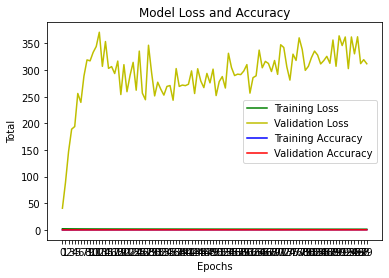

In [19]:
# Plot del training loss y el accuracy
def plot_prediction(n_epochs, mfit):
  loss = mfit.history['loss']
  val_loss = mfit.history['val_loss']

  accuracy = mfit.history['accuracy']
  val_accuracy = mfit.history['val_accuracy']

  epochs = range(0,n_epochs)

  plt.plot(epochs, loss, 'g', label='Training Loss')
  plt.plot(epochs, val_loss, 'y', label='Validation Loss')

  plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')

  plt.title('Model Loss and Accuracy')
  plt.xticks(epochs)
  plt.xlabel('Epochs')
  plt.ylabel('Total')
  plt.legend()
  plt.show()

plot_prediction(100, mfit_ann)

In [20]:
# Resultados
results_ann = model_ann.evaluate(X_test_gflat, test_labels, batch_size=128, verbose=1)
print(results_ann)

79/79 [==============================] - 0s 4ms/step - loss: 311.7035 - accuracy: 0.2905
[311.7034606933594, 0.2904999852180481]


## 3. Red Neuronal Convolucional de una capa [2.5 puntos]

A continuación implementaremos una red neuronal convolucional de una capa y realizaremos el entrenamiento y test sobre el dataset CIFAR.

Se recomienda, a partir de este punto realizar el entrenamiento en una máquina con GPU (puede activarse en plataformas como Google Colab o Kaggle) con el fin de reducir los tiempos de entrenamiento.

### 3.1 Pre-procesado de datos

El primer paso para entrenar una red neuronal consiste en pre-procesar los datos de entrenamiento y test para que cuadren con las dimensiones de la entrada de la red neuronal.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> Ajustar el tamaño de los datos de entrenamiento y test para que tengan 4 dimensiones (la última dimensión tiene que ser 1 para indicar que las imágenes están en escala de grises).
</div>

**Nota**: Utilizar el número de datos de entrenamiento y test y el tamaño de las imágenes.

In [21]:
X_train_g4dim = X_train_grey.reshape(50000,32,32,1)
X_test_g4dim = X_test_grey.reshape(10000,32,32,1)
X_train_g4dim.shape, X_test_g4dim.shape

((50000, 32, 32, 1), (10000, 32, 32, 1))

### 3.2 Creación del modelo


Se quiere implementar un modelo secuencial de Keras con las siguientes características:

- La primera capa que añadiremos será una capa convolucional con las siguientes propiedades: 
    - Número de kernels (neuronas) de la primera capa oculta: 64 neuronas
    - Tamaño de los kernels: 3x3
    - Activación de los kernels: ReLU
- A continuación añadiremos una capa Flatten para conectar la salida de la capa convolucional con la entrada de una capa densa.
- Por último, añadiremos una capa densa de salida con el número de neuronas y función de activación adecuadas para llevar a cabo la clasificación.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [1,5 pts.]:</strong> Construir el modelo según los requerimientos indicados, además:
<ul>
<li>   Imprime el modelo para ver el número de parámetros a entrenar.

<li>   Compila el modelo con la función de pérdida más adecuada, el optimizador ADAM y la métrica Accuracy.</li>

<li>   Ajusta el modelo con 20 épocas y un tamaño del batch de 128. Mide el tiempo de entrenamiento.</li>

<li>   Muestra las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación</li>
<li>   Realiza la evaluación del modelo para mostrar la pérdida y la precisión final. </li>
</div>
</ul>

In [22]:
# Crear la CNN monocapa
model_cnn_single = Sequential()

model_cnn_single.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32,32,1)))
model_cnn_single.add(Flatten())

# Capa softmax de clasificación con 10 valores posibles(etiqueas)
model_cnn_single.add(Dense(10, activation="softmax"))

In [23]:
# Compile
model_cnn_single.compile(Adam(learning_rate=0.01),
              "categorical_crossentropy",
              metrics=['accuracy'])

In [24]:
# Entrenamiento del modelo
epochs = 20
t0 = timeit.default_timer()
mfit_cnn_single = model_cnn_single.fit(X_train_g4dim, train_labels, epochs=epochs, batch_size=128,
                    validation_data=(X_test_g4dim, test_labels))
training_time_cnn_single = timeit.default_timer() - t0
print("El tiempo de entrenamiento de la red es {} segundos.".format(training_time_cnn_single))

Epoch 1/20
391/391 [==============================] - 12s 12ms/step - loss: 16.0611 - accuracy: 0.1000 - val_loss: 2.3032 - val_accuracy: 0.1011
Epoch 2/20
391/391 [==============================] - 4s 10ms/step - loss: 2.3018 - accuracy: 0.1017 - val_loss: 2.3030 - val_accuracy: 0.1003
Epoch 3/20
391/391 [==============================] - 4s 11ms/step - loss: 2.2979 - accuracy: 0.1066 - val_loss: 2.3064 - val_accuracy: 0.1044
Epoch 4/20
391/391 [==============================] - 4s 11ms/step - loss: 2.2893 - accuracy: 0.1109 - val_loss: 2.3105 - val_accuracy: 0.1037
Epoch 5/20
391/391 [==============================] - 4s 10ms/step - loss: 2.2764 - accuracy: 0.1164 - val_loss: 2.3204 - val_accuracy: 0.1041
Epoch 6/20
391/391 [==============================] - 4s 11ms/step - loss: 2.2596 - accuracy: 0.1244 - val_loss: 2.3522 - val_accuracy: 0.1048
Epoch 7/20
391/391 [==============================] - 4s 10ms/step - loss: 2.2444 - accuracy: 0.1309 - val_loss: 2.3636 - val_accuracy: 0.10

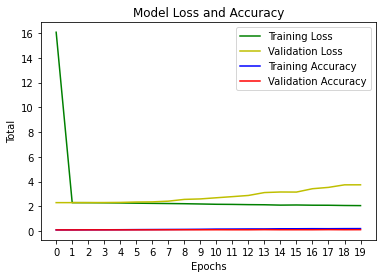

In [25]:
# Resultados
plot_prediction(epochs, mfit_cnn_single)

In [26]:
results_cnn_single = model_cnn_single.evaluate(X_test_g4dim, test_labels, batch_size=128, verbose=1)
print(results_cnn_single)

79/79 [==============================] - 0s 6ms/step - loss: 3.7419 - accuracy: 0.1191
[3.7418735027313232, 0.11909999698400497]


### 3.3 GPU vs CPU


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> Volver a entrenar el modelo desde cero en un entorno sin GPU (sólo con CPU) y compara los tiempos de entrenamiento. Comenta los resultados.
</div>

Con GPU: 95.6 segundos
Sin GPU: 682.33 segundos

## 4. Deep CNN con Maxpooling y Dropout [2 puntos]

En el ejercicio anterior hemos implementado una red convolucional de una sola capa. Ahora vamos a implementar una red neuronal convolucional profunda y veremos como esto se traduce en un mejor rendimiento en los resultados.

### 4.1 Creación del modelo


En este caso volveremos a utilizar el modelo `Sequential` de Keras que constará de: 
- Dos capas convolucionales de 32 kernels cada una de tamaño 3x3
- Una capa de MaxPooling con un tamaño de 2x2
- Una capa de Dropout con un rate=0.2
- Dos capas convolucionales de 64 kernels cada una de tamaño 3x3
- Una capa de MaxPooling con un tamaño de 2x2
- Una capa de Dropout con un rate=0.2
- Dos capas convolucionales de 128 kernels cada una de tamaño 3x3
- Una capa de MaxPooling con un tamaño de 2x2
- Una capa de Dropout con un rate=0.2
- Todas las capas convolucionales con función de activación ReLU y padding = same
- Una capa Flatten
- Una capa densa con 128 neuronas y función de activación ReLU
- Una capa de Dropout con un rate=0.2
- Una capa densa de salida con el número de neuronas y la función de activación necesarias para llevar a cabo la clasificación

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [1,5 pts.]:</strong> Construir el modelo según los requerimientos indicados, además:
<ul>
<li>   Imprime el modelo para ver el número de parámetros a entrenar.

<li>   Compila el modelo con la función de pérdida más adecuada, el optimizador SGD (con learning rate de 0.001 y momentum de 0.9) y la métrica Accuracy.</li>

<li>   Ajusta el modelo con 150 épocas y un tamaño del batch de 128. Mide el tiempo de entrenamiento.</li>

<li>   Muestra las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación</li>
<li>   Realiza la evaluación del modelo para mostrar la pérdida y la precisión final. </li>
</div>
</ul>
</div>

In [27]:
# Crear la CNN profunda
model_cnn_deep_grey = Sequential()

model_cnn_deep_grey.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(32,32,1)))
model_cnn_deep_grey.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_cnn_deep_grey.add(MaxPooling2D((2, 2)))
model_cnn_deep_grey.add(Dropout(.2))

model_cnn_deep_grey.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_cnn_deep_grey.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_cnn_deep_grey.add(MaxPooling2D((2, 2)))
model_cnn_deep_grey.add(Dropout(.2))

model_cnn_deep_grey.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model_cnn_deep_grey.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model_cnn_deep_grey.add(MaxPooling2D((2, 2)))
model_cnn_deep_grey.add(Dropout(.2))

model_cnn_deep_grey.add(Flatten())
model_cnn_deep_grey.add(Dense(128, activation='relu'))
model_cnn_deep_grey.add(Dropout(.2))

# Capa softmax de clasificación con 10 valores posibles(etiqueas)
model_cnn_deep_grey.add(Dense(10, activation="softmax"))

model_cnn_deep_grey.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

In [28]:
# Compile
model_cnn_deep_grey.compile(SGD(learning_rate=0.001, momentum=0.9),
              "categorical_crossentropy",
              metrics=['accuracy'])

In [29]:
# Entrenamiento del modelo
epochs = 150
t0 = timeit.default_timer()
mfit_cnn_deep_grey = model_cnn_deep_grey.fit(X_train_g4dim, train_labels, epochs=epochs, batch_size=128,
                    validation_data=(X_test_g4dim, test_labels))
training_time_cnn_deep_grey = timeit.default_timer() - t0
print("El tiempo de entrenamiento de la red es {} segundos.".format(training_time_cnn_deep_grey))

Epoch 1/150
391/391 [==============================] - 14s 34ms/step - loss: 2.2664 - accuracy: 0.1611 - val_loss: 1.9612 - val_accuracy: 0.3044
Epoch 2/150
391/391 [==============================] - 13s 32ms/step - loss: 1.9072 - accuracy: 0.2991 - val_loss: 1.7095 - val_accuracy: 0.3823
Epoch 3/150
391/391 [==============================] - 13s 32ms/step - loss: 1.7261 - accuracy: 0.3737 - val_loss: 1.5923 - val_accuracy: 0.4399
Epoch 4/150
391/391 [==============================] - 12s 32ms/step - loss: 1.5971 - accuracy: 0.4284 - val_loss: 1.4408 - val_accuracy: 0.4878
Epoch 5/150
391/391 [==============================] - 12s 32ms/step - loss: 1.4862 - accuracy: 0.4709 - val_loss: 1.3166 - val_accuracy: 0.5349
Epoch 6/150
391/391 [==============================] - 12s 32ms/step - loss: 1.3936 - accuracy: 0.5083 - val_loss: 1.2563 - val_accuracy: 0.5653
Epoch 7/150
391/391 [==============================] - 12s 32ms/step - loss: 1.3304 - accuracy: 0.5335 - val_loss: 1.2056 - val_ac

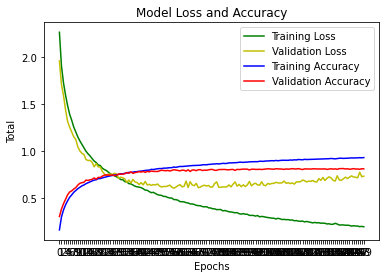

In [30]:
# Resultados
plot_prediction(epochs, mfit_cnn_deep_grey)

In [31]:
results_cnn_deep_grey = model_cnn_deep_grey.evaluate(X_test_g4dim, test_labels, batch_size=128, verbose=1)
print(results_cnn_deep_grey)

79/79 [==============================] - 1s 13ms/step - loss: 0.7335 - accuracy: 0.8112
[0.7335484623908997, 0.8112000226974487]


### 4.2 CNN con imágenes en color


Finalmente vamos a estudiar la influencia del color de las imágenes en la *performance* de la clasificación.

Para ello utilizaremos una red convolucional con la misma estructura de la red del apartado anterior pero cambiando la capa de entrada para que podamos introducir las imágenes originales en color, arrays de dimensión (32, 32, 3).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts]:</strong> Volver a realizar el ejercicio anterior pero modificando la capa de entrada para poder utilizar el conjunto de datos original, de tamaño (50000, 32, 32, 3) para el conjunto de train y (10000, 32, 32, 3) para el conjunto de test.

¿Influye el color de las imágenes en el resultado de la clasificación? Comentar el resultado.
</div>

**Nota**: Recordar normalizar las imágenes para que sus valores estén entre 0 y 1.

In [32]:
# Normalizar
# Manually compute MinMaxScaler as detailed in https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# Initialize values
min = 0
max = 1
X = X_train
# Normalize
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_train_norm = X_std * (max - min) + min
print("Los valores del primer registro de X_train_grey_norm son: {}".format(X_train_norm[0]))

Los valores del primer registro de X_train_grey_norm son: [[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]
  ...
  [0.61960784 0.51764706 0.42352941]
  [0.59607843 0.49019608 0.4       ]
  [0.58039216 0.48627451 0.40392157]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509804 0.21568627]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117647 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215686 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941176 0.19607843]
  [0.47058824 0.32941176 0.19607843]
  [0.42745098 0.28627451 0.16470588]]

 ...

 [[0.81568627 0.66666667 0.37647059]
  [0.78823529 0.6        0.13333333]
  [0.77647059 0.63137255 0.10196078]
  ...
  [0.62745098 0.52156863 0.2745098 ]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333333 0.07843137]]

 [[0.70588235 0.

In [33]:
# Determinar valores mínimo y máximo
v_min = np.min(X_train_norm)
v_max = np.max(X_train_norm)
print("Los valores mínimo y máximo son {} y {}.".format(v_min, v_max))

Los valores mínimo y máximo son 0.0 y 1.0.


In [34]:
# Crear la CNN profunda
model_cnn_deep_color = Sequential()

model_cnn_deep_color.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(32,32,3)))
model_cnn_deep_color.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_cnn_deep_color.add(MaxPooling2D((2, 2)))
model_cnn_deep_color.add(Dropout(.2))

model_cnn_deep_color.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_cnn_deep_color.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_cnn_deep_color.add(MaxPooling2D((2, 2)))
model_cnn_deep_color.add(Dropout(.2))

model_cnn_deep_color.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model_cnn_deep_color.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model_cnn_deep_color.add(MaxPooling2D((2, 2)))
model_cnn_deep_color.add(Dropout(.2))

model_cnn_deep_color.add(Flatten())
model_cnn_deep_color.add(Dense(128, activation='relu'))
model_cnn_deep_color.add(Dropout(.2))

# Capa softmax de clasificación con 10 valores posibles(etiqueas)
model_cnn_deep_color.add(Dense(10, activation="softmax"))

model_cnn_deep_color.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

In [35]:
# Compile
model_cnn_deep_color.compile(SGD(learning_rate=0.001, momentum=0.9),
              "categorical_crossentropy",
              metrics=['accuracy'])

In [36]:
# Entrenamiento del modelo
epochs = 150
t0 = timeit.default_timer()
mfit_cnn_deep_color = model_cnn_deep_color.fit(X_train_norm, train_labels, epochs=epochs, batch_size=128,
                    validation_data=(X_test, test_labels))
training_time_cnn_deep_color = timeit.default_timer() - t0
print("El tiempo de entrenamiento de la red es {} segundos.".format(training_time_cnn_deep_color))

Epoch 1/150
391/391 [==============================] - 14s 33ms/step - loss: 2.2986 - accuracy: 0.1110 - val_loss: 36.9187 - val_accuracy: 0.1000
Epoch 2/150
391/391 [==============================] - 13s 33ms/step - loss: 2.2503 - accuracy: 0.1576 - val_loss: 341.9738 - val_accuracy: 0.1002
Epoch 3/150
391/391 [==============================] - 13s 32ms/step - loss: 2.0565 - accuracy: 0.2404 - val_loss: 241.8085 - val_accuracy: 0.1369
Epoch 4/150
391/391 [==============================] - 13s 33ms/step - loss: 1.9689 - accuracy: 0.2782 - val_loss: 230.4026 - val_accuracy: 0.1795
Epoch 5/150
391/391 [==============================] - 13s 34ms/step - loss: 1.8852 - accuracy: 0.3137 - val_loss: 264.7092 - val_accuracy: 0.1824
Epoch 6/150
391/391 [==============================] - 13s 32ms/step - loss: 1.7851 - accuracy: 0.3506 - val_loss: 342.7823 - val_accuracy: 0.1594
Epoch 7/150
391/391 [==============================] - 13s 32ms/step - loss: 1.7063 - accuracy: 0.3768 - val_loss: 371.

KeyboardInterrupt: ignored

In [ ]:
# Resultados
plot_prediction(epochs, mfit_cnn_deep_color)

In [ ]:
results_cnn_deep_color = model_cnn_deep_color.evaluate(X_test, test_labels, batch_size=128, verbose=1)
print(results_cnn_deep_color)

## 5. Comparativa de los modelos implementados y predicción [1,5 puntos]

En este último apartado compararemos los modelos implementados y realizaremos la clasificación de algunas imágenes con el modelo que ha dado los mejores resultados.

### 5.1 Comparativa de los modelos implementados

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> Realizar una comparativa de los modelos implementados comentando:

*   La precisión obtenida
*   La pérdida
*   El tiempo de entrenamiento
*   El número de parámetros a entrenar

Comentar los resultados obtenidos.

En base a los resultados obtenidos ¿Qué modelo seleccionaríais como el mejor?
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Solución:</strong> 
</div>

### 5.2 Análisis de la mejor solución

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> Realizar un análisis de las medidas estadísticas más relevantes del modelo seleccionado en el apartado anterior y representar su matriz de confusión.

¿Qué clase es la que mejor se predice? ¿Y la que peor resultados obtiene?

Comentar los resultados
</div>

In [ ]:
# Informe
# TODO

In [ ]:
# Matriz de confusión
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

targets = ['airplane', 'automobile', 'bird'
    , 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=targets)
disp.plot()
plt.show()

### 5.3 Predicción de algunas imágenes del conjunto de test

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> Visualizar diez imágenes al azar del conjunto de test. Mostrar la etiqueta real y la predicción.
</div>

In [ ]:
# Visualización
# TODO